In [33]:
from pathlib import Path
from tira.rest_api_client import Client
from tira.third_party_integrations import get_output_directory
import pandas as pd
import numpy as np

In [34]:
tira = Client()

# loading train data
text_train = tira.pd.inputs(
    "nlpbuw-fsu-sose-24", "authorship-verification-train-20240408-training"
)
targets_train = tira.pd.truths(
    "nlpbuw-fsu-sose-24", "authorship-verification-train-20240408-training"
)
# loading validation data (automatically replaced by test data when run on tira)
text_validation = tira.pd.inputs(
    "nlpbuw-fsu-sose-24", "authorship-verification-validation-20240408-training"
)
targets_validation = tira.pd.truths(
    "nlpbuw-fsu-sose-24", "authorship-verification-validation-20240408-training"
)

### Token Frequency Distribution

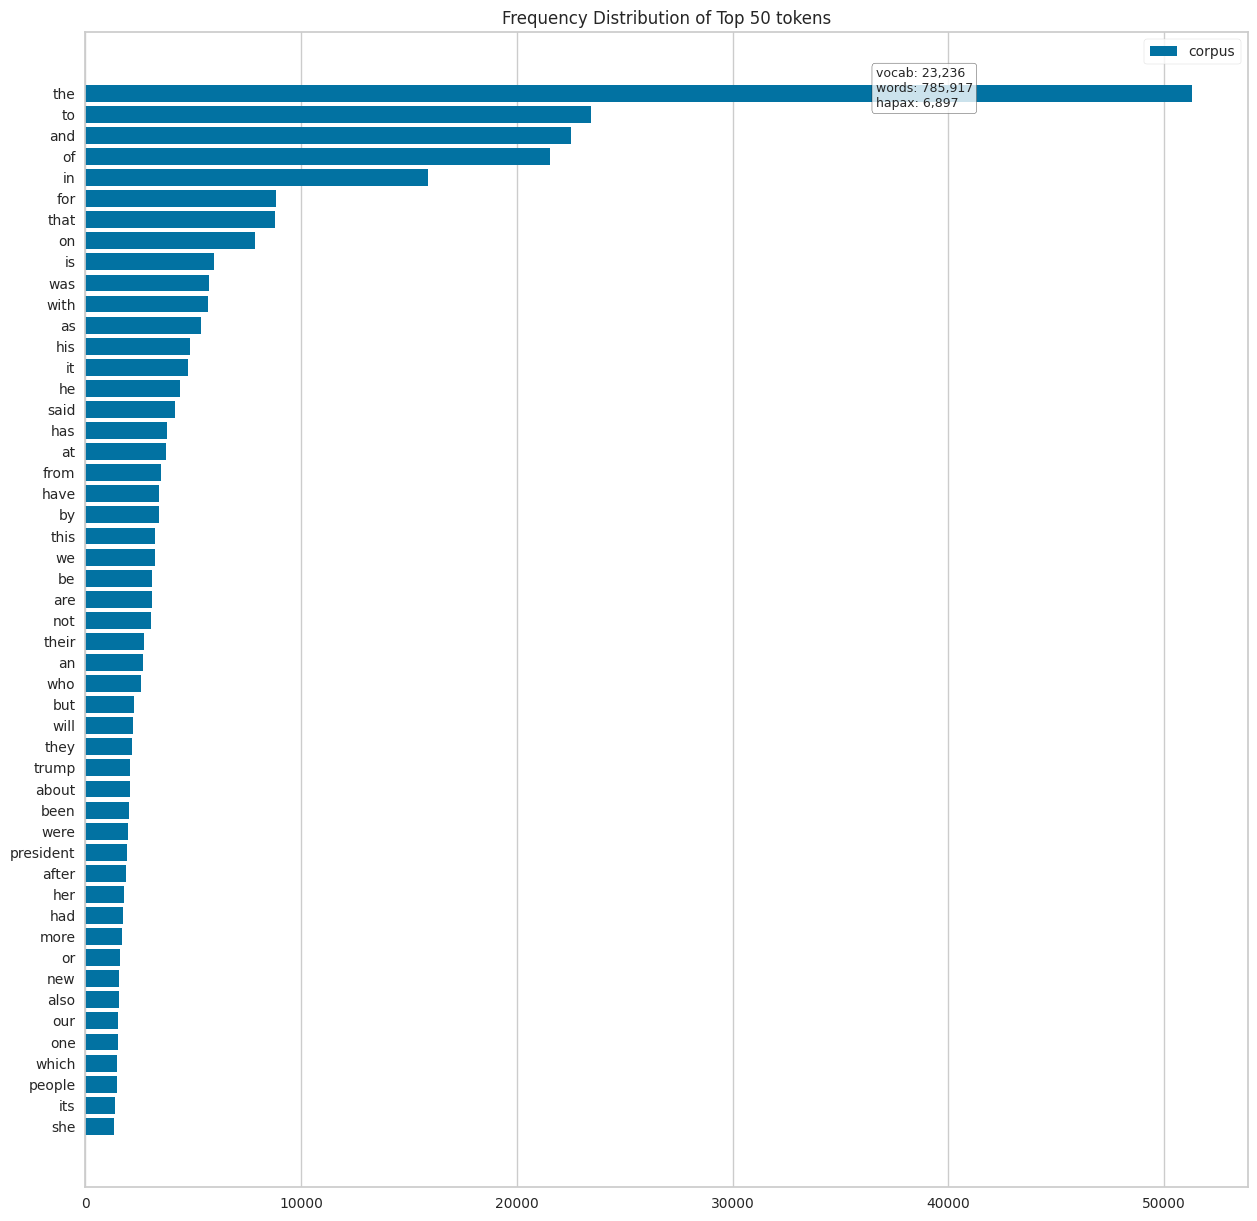

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt 

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(text_train["text"])
features = vectorizer.get_feature_names_out()
n_vocab = features.shape[0]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

visualizer = FreqDistVisualizer(features=features, orient='h', ax=ax)
visualizer.fit(docs)
visualizer.show()

## Relative token frequencies for generated and written texts

In [36]:
generated = text_train.loc[targets_train["generated"] == 1]
human_authored = text_train.loc[targets_train["generated"] == 0]

vectorizer = CountVectorizer(vocabulary=features)
docs_generated = vectorizer.fit_transform(generated["text"])
freqs_generated = np.array(np.sum(docs_generated, axis=0).T / np.sum(docs_generated))
freqs_generated = np.reshape(np.array(freqs_generated), (n_vocab, ))

vectorizer = CountVectorizer(vocabulary=features)
docs_human = vectorizer.fit_transform(human_authored["text"])
freqs_human = np.sum(docs_human, axis=0).T / np.sum(docs_human)
freqs_human = np.reshape(np.array(freqs_human), (n_vocab, ))

## Predicting

In [37]:
print(text_train["text"][166]) # Text 166 contains no words -> assumed to be generated

In [38]:
vectorizer = CountVectorizer(vocabulary=features)
docs = vectorizer.fit_transform(text_train["text"])
s = np.sum(docs, axis=1)
s[s == 0] = 1 # Avoid dividing by zero by adding 1 to the sum of text 166
freqs = (docs / s).toarray()
n_texts = text_train.shape[0]
prediction = np.zeros(shape=(n_texts,))
for i in range(n_texts):
    prediction[i] = np.sum(np.square(freqs_generated - freqs[i, :])) < np.sum(np.square(freqs_human - freqs[i, :]))

In [41]:
output_directory = get_output_directory('/workspaces/nlpbuw-fsu-sose-24-team-tapestry/authorship-verification-ru8')
pd.DataFrame(prediction, columns=['generated']).to_json(
        Path(output_directory) / "predictions.jsonl", orient="records", lines=True
    )